In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
from scipy.stats import ortho_group
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

from src.dt_helpers.network_dynamics import run_dynamics_step
from src.dt_helpers.plotters import visualize_network_activity
from src.dt_helpers.network_dynamics import compute_individual_neuron_frequency

In [3]:
weights_minicircuit = np.load("../../data/MANC weights/20241118_T1Lminicircuit/W_20241118_T1Lminicircuit.npy")
table_minicircuit= pd.read_csv("../../data/MANC weights/20241118_T1Lminicircuit/wTable_20241118_T1Lminicircuit.csv")
minicircuit_size = (table_minicircuit["class"] != "motor neuron").sum()
send_connections = (weights_minicircuit[np.arange(minicircuit_size)] != 0).any(0)
receive_connections = (weights_minicircuit[:, np.arange(minicircuit_size)] != 0).any(1)
keep = send_connections | receive_connections
weights_minicircuit = weights_minicircuit[keep][:, keep]
table_minicircuit = table_minicircuit[keep]
weights_minicircuit[table_minicircuit["class"] == "motor neuron"] = 0

# weights_freq_mod_circuit = np.load("../../data/MANC weights/20250213_testFreqModulatedNet/W.npy")
# table_freq_mod_circuit = pd.read_csv("../../data/MANC weights/20250213_testFreqModulatedNet/wTable.csv")

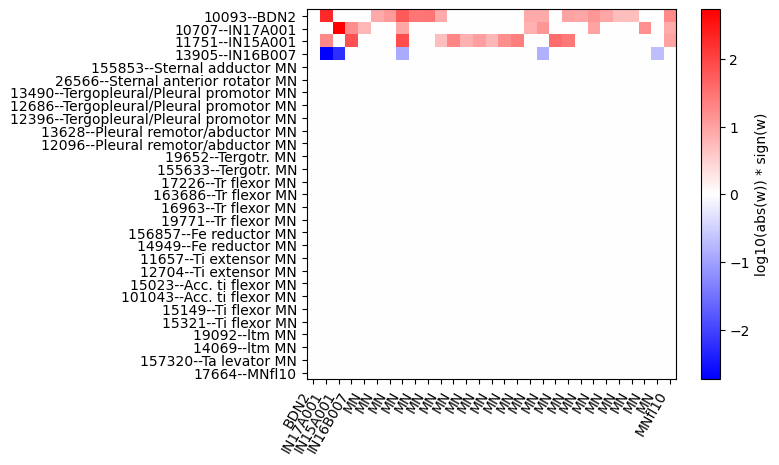

In [4]:
im_weights = np.log10(np.abs(weights_minicircuit) + 1e-10) * np.sign(weights_minicircuit)
vval = np.abs(im_weights).max()
plt.imshow(im_weights, cmap="bwr", vmin=-vval, vmax=vval)
plt.xticks(np.arange(keep.sum()), table_minicircuit["type"].apply(lambda x: x.split(" ")[-1]), rotation=60, ha="right")
plt.yticks(
    np.arange(keep.sum()), table_minicircuit[["bodyId", "type"]].apply(lambda x: "--".join([str(y) for y in x]), axis=1)
)
plt.colorbar(label="log10(abs(w)) * sign(w)")
plt.show()

In [28]:
network_size = minicircuit_size
network_input = np.zeros(keep.sum())
network_input[table_minicircuit["class"] == "descending neuron"] = 1
network_input = network_input[table_minicircuit["class"] != "motor neuron"]

network_weights = weights_minicircuit[:network_size, :network_size].T
eigenvalues, _ = np.linalg.eig(network_weights)
# normalization_factor = eigenvalues[0].real
normalization_factor = np.abs(eigenvalues).max()
# normalization_factor = 1
# normalization_factor = 1 / 0.275e-3
print(f"Normalization factor: {normalization_factor}")
network_weights = network_weights / normalization_factor

taus_s = 20e-3  # s
dt_s = 1e-5  # s

Normalization factor: 280.09681311984315


### Standard simulation

(<Figure size 2000x400 with 1 Axes>,
 <Axes: title={'center': 'Input intensity: 2'}, xlabel='Time (s)', ylabel='Rate (by neuron)'>)

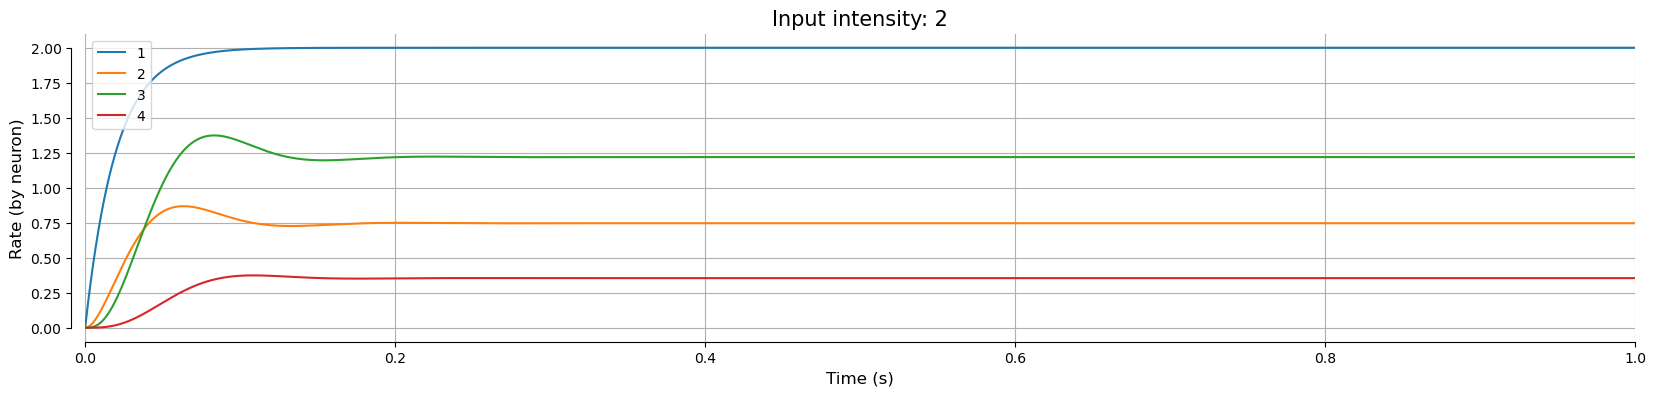

In [31]:
input_intensity = 2

simulation_time_s = 1
num_time_steps = int(simulation_time_s / dt_s)
current_rates = np.zeros(network_size)
history_rates = []
for i in range(num_time_steps):
    current_rates = run_dynamics_step(
        current_rates=current_rates,
        network_input=network_input * input_intensity,
        weights=network_weights,
        taus=taus_s,
        dt=dt_s,
        noise=0,
        # activations=lambda x: np.maximum(np.tanh(x / 10) * 10, 0),
        # activations=lambda x: np.tanh(x / 10) * 10,
        # activations = lambda x: np.maximum(x, -5),
        activations = lambda x: x,
    )
    history_rates.append(current_rates)
history_rates = np.array(history_rates)

visualize_network_activity(
    network_activity=history_rates,
    duration=simulation_time_s,
    dt=dt_s,
    title=f"Input intensity: {input_intensity}",
    legend_labels=[i+1 for i in range(network_size)],
    show_plot=False,
)

In [32]:
eigenvalues, eigenvectors = np.linalg.eig(network_weights)
print("eigenvals", eigenvalues)
print("eigenvals magnitude", np.abs(eigenvalues))
print("-----------------------------")
print("-----------------------------")
network_weights_star = (1 - dt_s / taus_s) * np.eye(network_size) + dt_s * network_weights / taus_s
eigenvalues, eigenvectors = np.linalg.eig(network_weights_star)
print("eigenvals", eigenvalues)
print("eigenvals magnitude", np.abs(eigenvalues))
print("eigenvalues angle (rad)", np.arctan2(eigenvalues.imag, eigenvalues.real))
print("estimated frequencies (Hz)", np.arctan2(eigenvalues.imag, eigenvalues.real) / dt_s / (2 * np.pi))

eigenvals [ 0.46363141+0.88602817j  0.46363141-0.88602817j -0.92726282+0.j
  0.        +0.j        ]
eigenvals magnitude [1.         1.         0.92726282 0.        ]
-----------------------------
-----------------------------
eigenvals [0.99973182+0.00044301j 0.99973182-0.00044301j 0.99903637+0.j
 0.9995    +0.j        ]
eigenvals magnitude [0.99973191 0.99973191 0.99903637 0.9995    ]
eigenvalues angle (rad) [ 0.00044313 -0.00044313  0.          0.        ]
estimated frequencies (Hz) [ 7.05267909 -7.05267909  0.          0.        ]


In [21]:
freqs = compute_individual_neuron_frequency(
    history_rates,
    dt=dt_s,
    num_steps=num_time_steps,
    max_frequency=30,
    use_interpolation=True,
)
[(f"neuron-{k}", v) for k, v in freqs.items() if len(k) == 1]

[('neuron-0', 0),
 ('neuron-1', np.float64(15.04986454264035)),
 ('neuron-2', np.float64(15.04986454264035)),
 ('neuron-3', np.float64(15.04986454264035))]

In [ ]:
15.149863642591448

### Frequency modulation with input

In [152]:
input_intensities = np.linspace(0.1, 30, 30)

simulation_time_s = 0.3

num_time_steps = int(simulation_time_s / dt_s)
individual_neuron_frequencies = pd.DataFrame()
for input_intensity in input_intensities:
    current_rates = np.zeros(network_size)
    history_rates = []
    for i in range(num_time_steps):
        current_rates = run_dynamics_step(
            current_rates=current_rates,
            network_input=network_input * input_intensity,
            weights=network_weights,
            taus=taus_s,
            dt=dt_s,
            noise=0,
            activations=lambda x: np.maximum(np.tanh(x / 10) * 10, 0),
            # activations=lambda x: np.tanh(x / 10) * 10,
            # activations=lambda x: np.maximum(x, 0),
            # activations=lambda x: x,
        )
        history_rates.append(current_rates)
    history_rates = np.array(history_rates)
    temp_indi_freq = compute_individual_neuron_frequency(
        history_rates,
        dt=dt_s,
        num_steps=num_time_steps,
        max_frequency=30,
        use_interpolation=True,
    )
    temp_indi_freq = pd.Series(temp_indi_freq)
    temp_indi_freq.name = "frequency"
    temp_indi_freq = temp_indi_freq.to_frame()
    temp_indi_freq["input_intensity"] = input_intensity
    individual_neuron_frequencies = pd.concat([individual_neuron_frequencies, temp_indi_freq], axis=0)
individual_neuron_frequencies = individual_neuron_frequencies.reset_index()

In [ ]:
sns.lineplot(
    data=individual_neuron_frequencies,
    x="input_intensity",
    y="frequency",
    hue="index",
    palette="tab10",
    size="index",
    sizes=(2, 10),
)
plt.ylim(0)
sns.despine(offset=1, trim=True)
plt.show()